In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.sparse
pd.set_option("display.max_columns",101)
RANDOM_STATE = 42
DATA_PATH = "../data/instacart/"

In [6]:
print('loading prior')
priors = pd.read_csv(DATA_PATH + 'order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})


print('loading orders')
orders = pd.read_csv(DATA_PATH + 'orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})
orders.set_index('order_id', inplace=True, drop=False)

print('loading train')
train = pd.read_csv(DATA_PATH + 'order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print ('split orders: train, test')
priors.drop('order_id_', inplace=True, axis=1)
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

loading prior
loading orders
loading train
split orders: train, test


In [8]:
users = pd.read_csv(DATA_PATH + "users_match.csv", dtype={
    'total_items': np.int32,
    'total_distinct_items': np.int32,
    'average_days_between_orders': np.float32,
    'nb_orders': np.int32,
    'average_basket': np.float32
})
users.set_index('user_id', inplace=True)
def xx(a):
    tmp = a.strip()[5:-2].split(",")
    result = [int(x) for x in tmp if x]
    return result
users['all_products'] = users['all_products'].apply(xx)

products = pd.read_csv(DATA_PATH + "products_match.csv", dtype={
    'product_id': np.int32,
    'aisle_id': np.int32,
    'department_id': np.int32,
    'orders': np.float32,
    'reorders': np.float32,
    'reorder_rate': np.float64
})

products.set_index('product_id.1', inplace=True)

userXproduct = pd.read_csv(DATA_PATH + "user_product_match.csv", index_col=0, dtype={
    'np_orders': np.int32,
    'last_order_id': np.int32,
    'sum_pos_in_cart': np.int32,
})

In [9]:
def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%10000 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        if user_id not in users.all_products:
            continue
            
        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in train.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    df.head()
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    print('order related features')
    df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders)
    df['product_reorders'] = df.product_id.map(products.reordered)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x))
    #df['UP_same_dow_as_last_order'] = df.UP_last_order_id.map(orders.order_dow) == \
    #                                              df.order_id.map(orders.order_dow)

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)

In [11]:
df_train, labels = features(train_orders, labels_given=True)

f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last'] # 'dow', 'UP_same_dow_as_last_order'

build candidate list
('order row', 10000)
('order row', 20000)
('order row', 30000)
('order row', 40000)
('order row', 50000)
('order row', 60000)
('order row', 70000)
('order row', 80000)
('order row', 90000)
('order row', 100000)
('order row', 110000)
('order row', 120000)
('order row', 130000)
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int32
user_total_items                      int32
total_distinct_items                  int32
user_average_days_between_orders    float32
user_average_basket                 float32
dow                                    int8
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              int32
department_id                         int32
product_orders              

In [12]:
df_train.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,dow,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last
0,1187899,17122,11,59,18,19.0,5.363636,4,8,14.0,0.736842,24,4,13880.0,9377.0,0.675576,1,0.090909,6.000000,0.090909,6,7
1,1187899,196,11,59,18,19.0,5.363636,4,8,14.0,0.736842,77,7,35791.0,27791.0,0.776480,10,0.909091,1.400000,0.909091,1,0
2,1187899,26405,11,59,18,19.0,5.363636,4,8,14.0,0.736842,54,17,1214.0,536.0,0.441516,2,0.181818,5.000000,0.181818,7,1
3,1187899,13032,11,59,18,19.0,5.363636,4,8,14.0,0.736842,121,14,3751.0,2465.0,0.657158,3,0.272727,6.333333,0.272727,1,0
4,1187899,39657,11,59,18,19.0,5.363636,4,8,14.0,0.736842,45,19,5019.0,3846.0,0.766288,1,0.090909,3.000000,0.090909,1,0


In [13]:
m = int(len(labels) * 0.8)
df_train_data = df_train[:m]
label_train = labels[:m]

In [14]:
df_test_dat = df_train[m:]
label_test = labels[m:]

In [52]:
import lightgbm as lgb
d_train = lgb.Dataset(df_train_data[f_to_use],
                      label=label_train,
                      categorical_feature=['aisle_id', 'department_id']) 
d_test = lgb.Dataset(df_test_dat[f_to_use],
                      label=label_test,
                      categorical_feature=['aisle_id', 'department_id'])

In [87]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'learning_rate': 0.05,
    'min_data_in_leaf': 50,
    'lambda_l2': 0.5,
}
ROUNDS = 400

print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS, valid_sets=[d_test,], early_stopping_rounds=10)
# lgb.plot_importance(bst, figsize=(9,20))

light GBM train :-)
[1]	valid_0's auc: 0.818835
Train until valid scores didn't improve in 10 rounds.
[2]	valid_0's auc: 0.821671
[3]	valid_0's auc: 0.82169
[4]	valid_0's auc: 0.821874
[5]	valid_0's auc: 0.822429
[6]	valid_0's auc: 0.822937
[7]	valid_0's auc: 0.823118
[8]	valid_0's auc: 0.823277
[9]	valid_0's auc: 0.823329
[10]	valid_0's auc: 0.823443
[11]	valid_0's auc: 0.823475
[12]	valid_0's auc: 0.823196
[13]	valid_0's auc: 0.823624
[14]	valid_0's auc: 0.823879
[15]	valid_0's auc: 0.824007
[16]	valid_0's auc: 0.823855
[17]	valid_0's auc: 0.824199
[18]	valid_0's auc: 0.82393
[19]	valid_0's auc: 0.824236
[20]	valid_0's auc: 0.824496
[21]	valid_0's auc: 0.8247
[22]	valid_0's auc: 0.824503
[23]	valid_0's auc: 0.824799
[24]	valid_0's auc: 0.824917
[25]	valid_0's auc: 0.824779
[26]	valid_0's auc: 0.825017
[27]	valid_0's auc: 0.825243
[28]	valid_0's auc: 0.825091
[29]	valid_0's auc: 0.825324
[30]	valid_0's auc: 0.82552
[31]	valid_0's auc: 0.825679
[32]	valid_0's auc: 0.825778
[33]	valid_0

In [56]:
bst.best_iteration

276

In [88]:
preduct_result =bst.predict(df_train_data[f_to_use], num_iteration=bst.best_iteration)
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(label_train, preduct_result)
metrics.auc(fpr, tpr)

0.83891768388151022

In [89]:
preduct_result =bst.predict(df_test_dat[f_to_use], num_iteration=bst.best_iteration)

#### 分析错误数据和真实数据的区别，增加新的特征数据

In [90]:
result = preduct_result > 0.22
wrong_index = result != label_test
right_index = result == label_test

In [91]:
right_test_data = df_test_dat.ix[right_index]
right_test_label = label_test[right_index]
wrong_test_data = df_test_dat.ix[wrong_index]
wrong_test_label = label_test[wrong_index]

In [92]:
right_test_data.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,dow,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last
6779728,769244,6375,70,1129,226,5.275362,16.128571,5,15,3.0,0.568681,3,19,817.0,547.0,0.669523,1,0.014286,19.000000,0.014286,69,3
6779729,769244,8174,70,1129,226,5.275362,16.128571,5,15,3.0,0.568681,24,4,42721.0,27332.0,0.639779,1,0.014286,21.000000,0.014286,66,3
6779730,769244,24810,70,1129,226,5.275362,16.128571,5,15,3.0,0.568681,78,19,8357.0,4654.0,0.556898,6,0.085714,9.166667,0.085714,16,1
6779731,769244,46631,70,1129,226,5.275362,16.128571,5,15,3.0,0.568681,94,7,284.0,134.0,0.471831,4,0.057143,13.250000,0.057143,11,5
6779732,769244,41198,70,1129,226,5.275362,16.128571,5,15,3.0,0.568681,88,13,3828.0,1618.0,0.422675,8,0.114286,15.000000,0.114286,27,2


In [93]:
wrong_test_data.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,dow,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last
6779747,769244,33037,70,1129,226,5.275362,16.128571,5,15,3.0,0.568681,93,3,4199.0,2813.0,0.669921,22,0.314286,11.272727,0.314286,3,7
6779761,769244,19677,70,1129,226,5.275362,16.128571,5,15,3.0,0.568681,91,16,14712.0,10927.0,0.742727,15,0.214286,10.200000,0.214286,4,5
6779828,769244,33754,70,1129,226,5.275362,16.128571,5,15,3.0,0.568681,120,16,29893.0,22419.0,0.749975,12,0.171429,8.166667,0.171429,3,7
6779843,2492692,24964,9,39,29,26.375000,4.333333,1,9,30.0,1.137441,83,4,109778.0,74663.0,0.680127,3,0.333333,4.333333,0.333333,1,5
6779844,2492692,14218,9,39,29,26.375000,4.333333,1,9,30.0,1.137441,86,16,8568.0,6238.0,0.728058,2,0.222222,1.500000,0.222222,1,5


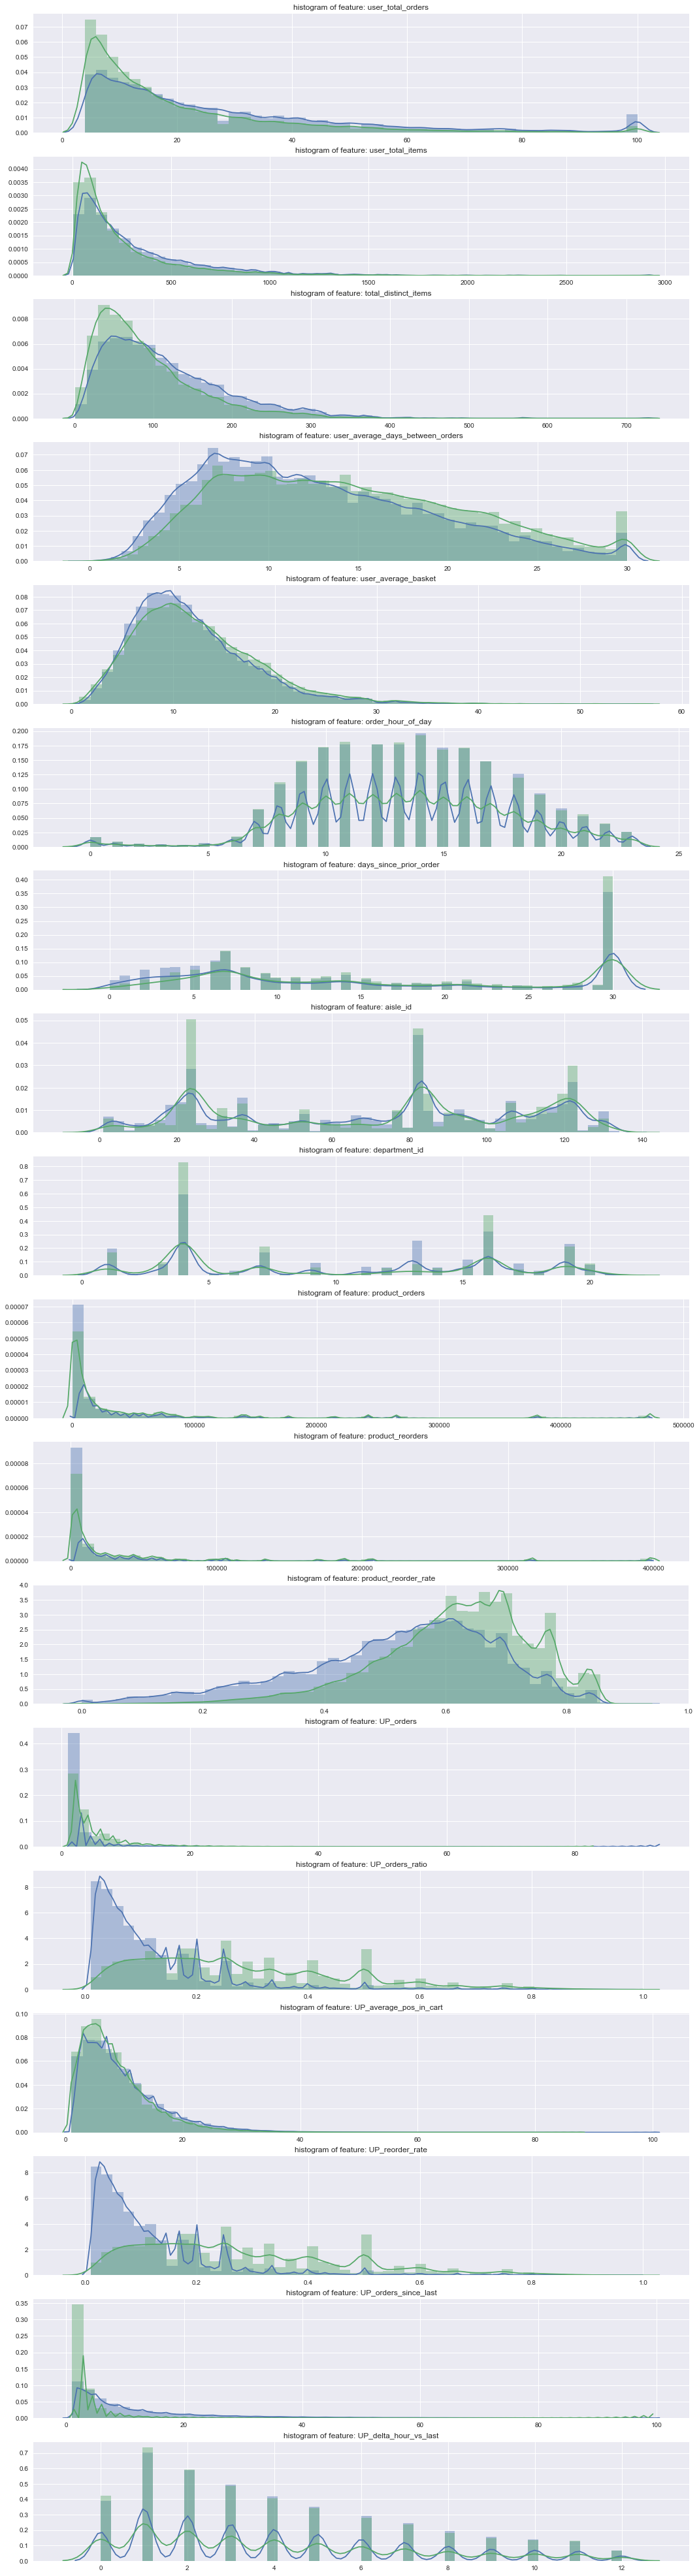

In [96]:
import matplotlib.gridspec as gridspec
import seaborn as sns
v_features = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last']
plt.figure(figsize=(len(v_features),28*4))
gs = gridspec.GridSpec(28, 1)

for i, cn in enumerate(df_test_dat[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df_test_dat[cn][right_index], bins=50, label='wrong')
    sns.distplot(df_test_dat[cn][wrong_index], bins=50, label='right')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

In [83]:
max_i = None
max_f = 0
from sklearn.metrics import f1_score
for i in range(1, 100, 1):
    result = preduct_result > i / 100.0
    xx = f1_score(label_test, result)
    if xx > max_f:
        max_f = xx
        max_i = i
    print i, xx
    
print "max_i", max_i, max_f

1 0.197485170358
2 0.228206310128
3 0.255243280049
4 0.278924985993
5 0.300383459977
6 0.319620160504
7 0.33673771517
8 0.352183906823
9 0.366042003694
10 0.378225401145
11 0.389179308488
12 0.399041342121
13 0.407682215663
14 0.414519987519
15 0.420219821102
16 0.425131913561
17 0.429409049652
18 0.432697680515
19 0.435581385346
20 0.437366735097
21 0.438358343769
22 0.43849413238
23 0.438238276646
24 0.437433756631
25 0.435872513299
26 0.433851563225
27 0.430952322317
28 0.427842708419
29 0.423964568027
30 0.420020931276
31 0.414902302291
32 0.410372990398
33 0.404267969226
34 0.398548722498
35 0.392687388454
36 0.386945363424
37 0.380248800577
38 0.373120297055
39 0.365814977974
40 0.358084867059
41 0.350448288297
42 0.342641668422
43 0.335274161601
44 0.327045173066
45 0.31826344003
46 0.309755748156
47 0.300903755282
48 0.292506740529
49 0.283452969143
50 0.275210312012
51 0.26643486235
52 0.258068256484
53 0.248870082722
54 0.239714623096
55 0.230935122506
56 0.222540365876
57 0.

In [29]:
df_test, _ = features(test_orders)

build candidate list
('order row', 10000)
('order row', 20000)
('order row', 30000)
('order row', 40000)
('order row', 50000)
('order row', 60000)
('order row', 70000)
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int32
user_total_items                      int32
total_distinct_items                  int32
user_average_days_between_orders    float32
user_average_basket                 float32
dow                                    int8
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              int32
department_id                         int32
product_orders                      float32
product_reorders                    float64
product_reorder_rate                float64
UP_orders                 

In [84]:
print('light GBM predict')
preds = bst.predict(df_test[f_to_use], num_iteration=bst.best_iteration)

light GBM predict


In [85]:
result_pred = preds > 0.22
sum(result_pred)

602897

In [86]:
df_test['pred'] = preds

TRESHOLD = max_i/100.0  # guess, should be tuned with crossval on a subset of train data

d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv(DATA_PATH + 'sub.csv', index=False)